In [1]:
import healpy as hp
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
import os
import matplotlib.pyplot as plt
from healpy import read_map
tf.keras.backend.clear_session() #clear any previous models

data_directory = "/cosmodata/iocampo/SkySimulation/data/"
os.chdir(data_directory)
os.environ['CUDA_VISIBLE_DEVICES'] = '-1' #disable GPU
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"  #suppress TF warnings
print("Current working directory:", os.getcwd())

2025-06-24 10:21:46.767158: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-24 10:21:46.847389: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-24 10:21:46.848943: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-06-24 10:21:48.664479: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Current working directory: /cosmodata/iocampo/SkySimulation/data


In [2]:
from astropy.io import fits
def read_map(file_path):
    """
    Reads a Healpy map from a FITS file and flattens the data.
    """
    
    with fits.open(file_path) as hdul:
        hdul.info()
        if len(hdul) > 1 and hasattr(hdul[1], 'columns'):
            print(hdul[1].columns)
        return np.concatenate(hdul[1].data['T'])

Filename: ./simulated_maps/cmb_map_0.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1  xtension      1 BinTableHDU     18   192R x 1C   [1024D]   
ColDefs(
    name = 'T'; format = '1024D'
)
NSIDE: 128


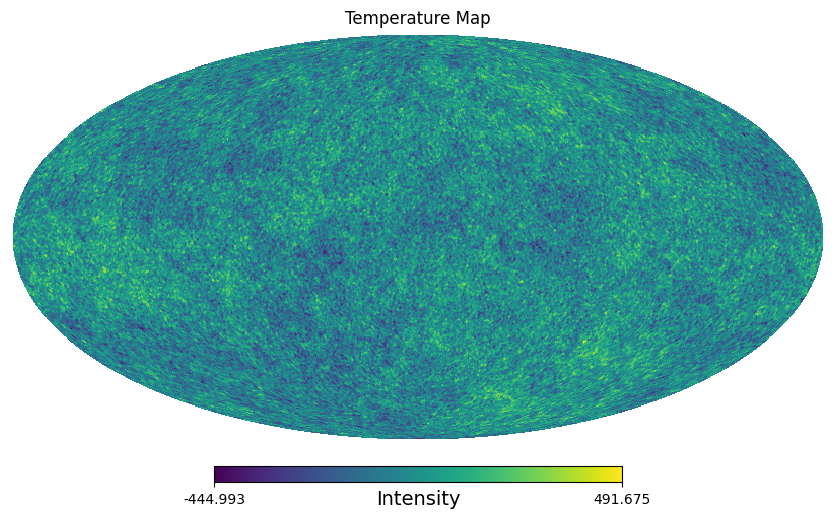

In [3]:
#Read the data
path_lcdm = "./simulated_maps/"
map_temp_data = read_map(path_lcdm + 'cmb_map_0.fits')

#Visualize the map
nside = hp.npix2nside(len(map_temp_data))
#nside = 64
print(f"NSIDE: {nside}")

#Plot
hp.mollview(map_temp_data, title="Temperature Map", unit="Intensity")
plt.show()

In [4]:
def read_all_maps(path_lcdm, path_feature, n_maps=100):
    maps = []
    labels = []
    
    #LCDM maps
    for i in range(n_maps):
        map_lcdm = read_map(f"{path_lcdm}cmb_map_{i}.fits")
        maps.append(map_lcdm)
        labels.append(0)  #lcdm
    
    #Feature maps
    for i in range(n_maps):
        map_feature = read_map(f"{path_feature}cmb_map_feature_{i}.fits")
        maps.append(map_feature)
        labels.append(1)  #feature
    
    maps = np.array(maps).astype(np.float32)[..., None]  #Add channel dimension
    labels = np.array(labels).astype(np.int32)
    #print(labels)
    return maps, labels

In [5]:
path_feature = "./simulated_maps/"
x_raw, y_raw = read_all_maps(path_lcdm, path_feature, n_maps=100) #0: lcdm, 1:feature

Filename: ./simulated_maps/cmb_map_0.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1  xtension      1 BinTableHDU     18   192R x 1C   [1024D]   
ColDefs(
    name = 'T'; format = '1024D'
)
Filename: ./simulated_maps/cmb_map_1.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1  xtension      1 BinTableHDU     18   192R x 1C   [1024D]   
ColDefs(
    name = 'T'; format = '1024D'
)
Filename: ./simulated_maps/cmb_map_2.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1  xtension      1 BinTableHDU     18   192R x 1C   [1024D]   
ColDefs(
    name = 'T'; format = '1024D'
)
Filename: ./simulated_maps/cmb_map_3.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1  xtension      1 BinTableHDU     18   192R x 1C  

In [6]:
maps_model = np.atleast_2d(x_raw)
print("Shape of maps_model:", maps_model.shape)

Shape of maps_model: (200, 196608, 1)


In [ ]:
maps_model = 

In [7]:
#Normalize:
X = (maps_model - np.mean(maps_model, axis=1, keepdims=True)) / np.std(maps_model, axis=1, keepdims=True)

The history saving thread hit an unexpected error (OperationalError('database is locked')).History will not be written to the database.


In [8]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y_raw, test_size=0.2, random_state=42)

In [9]:
#======== Define Model ========
#model = models.Sequential([
#    layers.Input(shape=(X.shape[1],)),
#    layers.Dense(512, activation='relu'),
#    layers.Dropout(0.2),
#    layers.Dense(256, activation='relu'),
#    layers.Dropout(0.),
#    layers.Dense(84, activation='relu'),
#    layers.Dropout(0.),
#    layers.Dense(1, activation='sigmoid')
#])

In [10]:
#Model suggested by Optuna: FULLY CONNECTED NEURAL NETWORK
model = models.Sequential()
model.add(layers.Input(shape=(X.shape[1],)))  # Input layer

model.add(layers.Dense(192, activation='relu'))
model.add(layers.Dropout(0.14345855519676617))

model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.14345855519676617))

model.add(layers.Dense(192, activation='relu'))
model.add(layers.Dropout(0.14345855519676617))

model.add(layers.Dense(320, activation='relu'))
model.add(layers.Dropout(0.14345855519676617))

# Output layer
model.add(layers.Dense(1, activation='sigmoid'))

# Optimizer (SGD with the selected learning rate)
optimizer = tf.keras.optimizers.SGD(learning_rate=5.598157724953616e-05)

In [ ]:
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=[tf.keras.metrics.BinaryAccuracy()])
model.summary(110)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                                   ┃ Output Shape                        ┃             Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                                  │ (None, 192)                         │          37,748,928 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ dropout (Dropout)                              │ (None, 192)                         │                   0 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ dense_1 (Dense)                                │ (None, 128)                         │              24,704 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ dropout_1 (Dropout)                            │ (None, 128)                         │                   0 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ dense_2 (Dense)                                │ (None, 192)                         │              24,768 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ dropout_2 (Dropout)                            │ (None, 192)                         │                   0 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ dense_3 (Dense)                                │ (None, 320)                         │              61,760 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ dropout_3 (Dropout)                            │ (None, 320)                         │                   0 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ dense_4 (Dense)                                │ (None, 1)                           │                 321 │
└────────────────────────────────────────────────┴─────────────────────────────────────┴─────────────────────┘

 Total params: 37,860,481 (144.43 MB)

 Trainable params: 37,860,481 (144.43 MB)

 Non-trainable params: 0 (0.00 B)

: 

In [ ]:
history = model.fit(X_train, y_train, epochs=500, batch_size=32, validation_split=0.2)

Epoch 1/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 733ms/step - binary_accuracy: 0.5319 - loss: 0.7435

In [ ]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_acc:.4f}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 5s/step - accuracy: 0.5375 - loss: 0.6931
Test accuracy: 0.5250


In [ ]:
#Function for the probability of classification as LCDM 
def normFeat(p):
  if 0<p<0.5:
    rr=1-p
  else:
    rr=p
  return rr

#Function for the probability of classification as Feature 
def normLCDM(p):
  if 0<p<0.5:
    rr=p
  else:
    rr=1-p
  return rr

In [ ]:
theory = ['LCDM','FT']

true_model=[]
pred_model=[]
prob_pred_MoG=[]
prob_pred_LCDM=[]
for i in range(len(X_test)):
  X_test_tf = tf.convert_to_tensor([X_test[i]])
  predictions = model.predict(X_test_tf)
  true_model.append(round(y_test[i]))
  pred_model.append(round(predictions[0][0]))
  prob_pred_MoG.append(round(100*normFeat(predictions[0][0]),3))
  prob_pred_LCDM.append(round(100*normLCDM(predictions[0][0]),3))

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━

Text(0, 0.5, 'Accuracy')

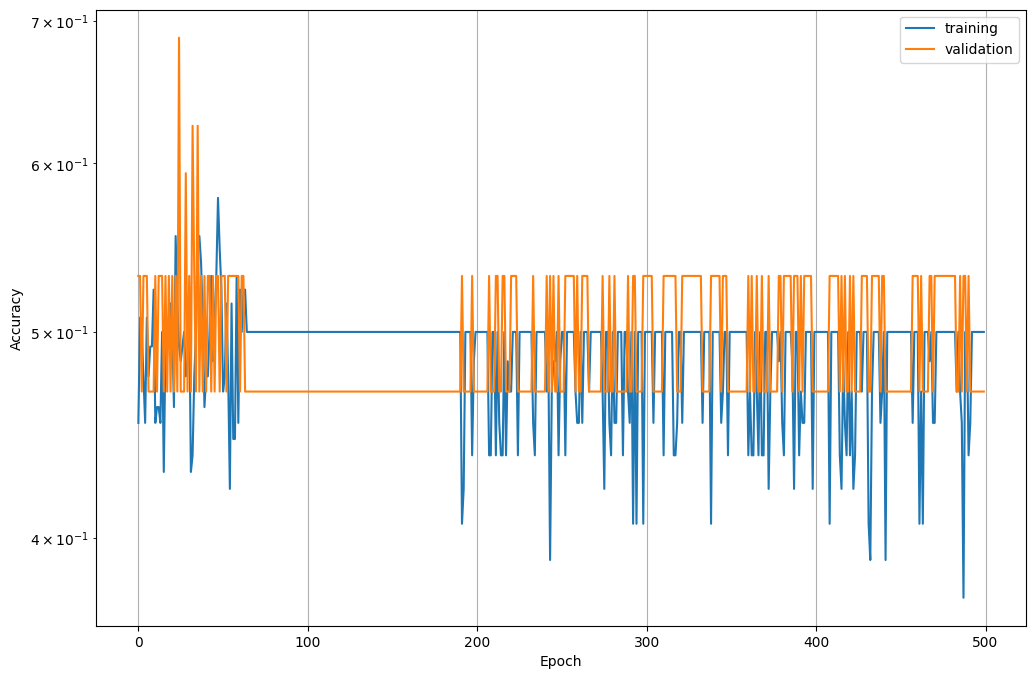

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(history.history["accuracy"], label="training")
plt.plot(history.history["val_accuracy"], label="validation")
plt.grid()
plt.yscale("log")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Accuracy")

Text(0, 0.5, 'Loss')

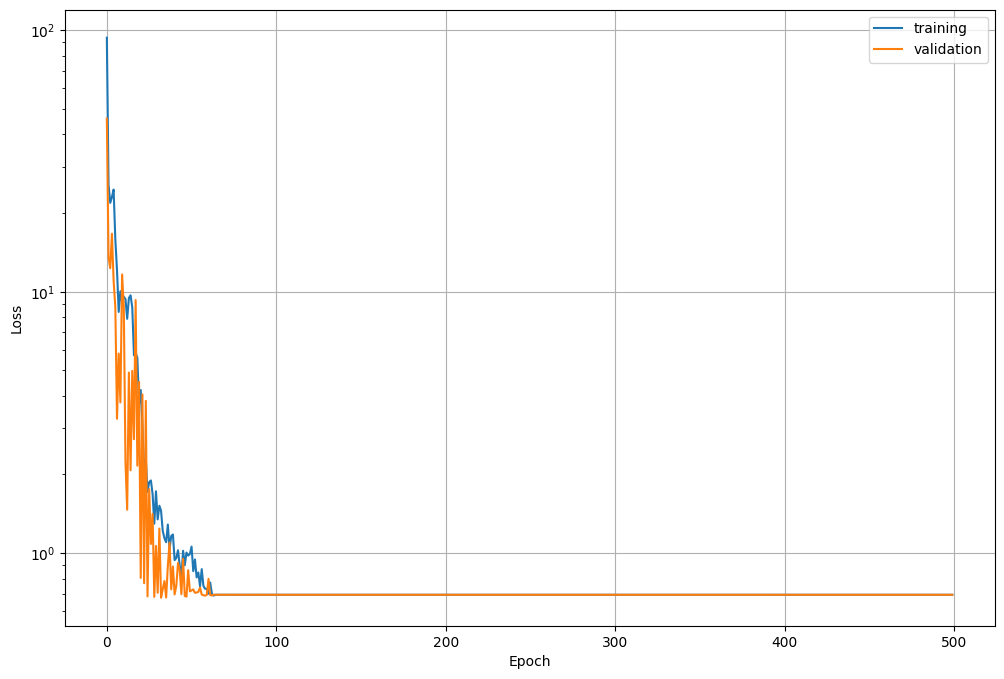

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(history.history["loss"], label="training")
plt.plot(history.history["val_loss"], label="validation")
plt.grid()
plt.yscale("log")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")

In [ ]:
#-----------------------------------------------------------------------------------------------------------
#Performance: correct & incorrect  predictions
#-----------------------------------------------------------------------------------------------------------
true_LCDM = []
true_MoG = []
false_LCDM = []
false_MoG = []

for pred, true in zip(pred_model, true_model):
    if pred==0 and true==0:
        true_LCDM.append(1)
    if pred==1 and true==1:
        true_MoG.append(1)
    if pred==0 and true==1:
        false_LCDM.append(1)
    if pred==1 and true==0:
        false_MoG.append(1)
lenghts=[len(true_LCDM),len(true_MoG),len(false_LCDM),len(false_MoG)]

print('     ','LCDM','FT')
print('True ',len(true_LCDM)/sum(lenghts),len(true_MoG)/sum(lenghts))
print('False',len(false_LCDM)/sum(lenghts),len(false_MoG)/sum(lenghts))
print('--------------')
print("Correct prediction: ",(len(true_LCDM)+len(true_MoG))/sum(lenghts))
print("Wrong prediction  : ",(len(false_LCDM)+len(false_MoG))/sum(lenghts))

      LCDM FT
True  0.525 0.0
False 0.475 0.0
--------------
Correct prediction:  0.525
Wrong prediction  :  0.475
